In [62]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib
import matplotlib.pyplot as plt
import math
import datetime


CSV_URL = "https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv"

csv_string = requests.get(CSV_URL).content
df = pd.read_csv(io.StringIO(csv_string.decode('utf-8')))


In [80]:
origin_datetime = datetime.datetime.strptime(df['Date'][0], '%Y-%m-%d')
countries = {'China': None, 'Italy': None, 'France': None, 'Spain': None, 'US': None, 'United Kingdom': None}
#df.head()

VERBOSE = 0

In [81]:
df_plot = pd.DataFrame()
# show unique countries
#np.unique(df['Country'])
min_offset = 99999999999
for country in countries:
    if VERBOSE:
        print("Processing: {}".format(country))
    cc = df[df['Country'] == country]['Confirmed'].tolist()
    if VERBOSE:
        print("Initial Len: {}".format(len(cc)))
    countries[country] = 0
    while cc[0] < 1000:
        cc = np.delete(cc, 0)
        cc = np.append(cc, [0])
        countries[country] += 1
    if VERBOSE:
        print("Final Len: {}, steps: {}".format(len(cc), countries[country]))
    df_plot[country] = cc
    if countries[country] < min_offset:
        min_offset = countries[country]


In [82]:
#df_plot.head()

China --> peak: Feb 16 ; final total cases = 80000.0 ; time constant = 4.0 days
Italy --> peak: Mar 22 ; final total cases = 117000.0 ; time constant = 5.4 days
France --> peak: Mar 30 ; final total cases = 105000.0 ; time constant = 5.4 days
Spain --> peak: Mar 31 ; final total cases = 181000.0 ; time constant = 5.0 days
US --> peak: Apr 02 ; final total cases = 317000.0 ; time constant = 3.8 days


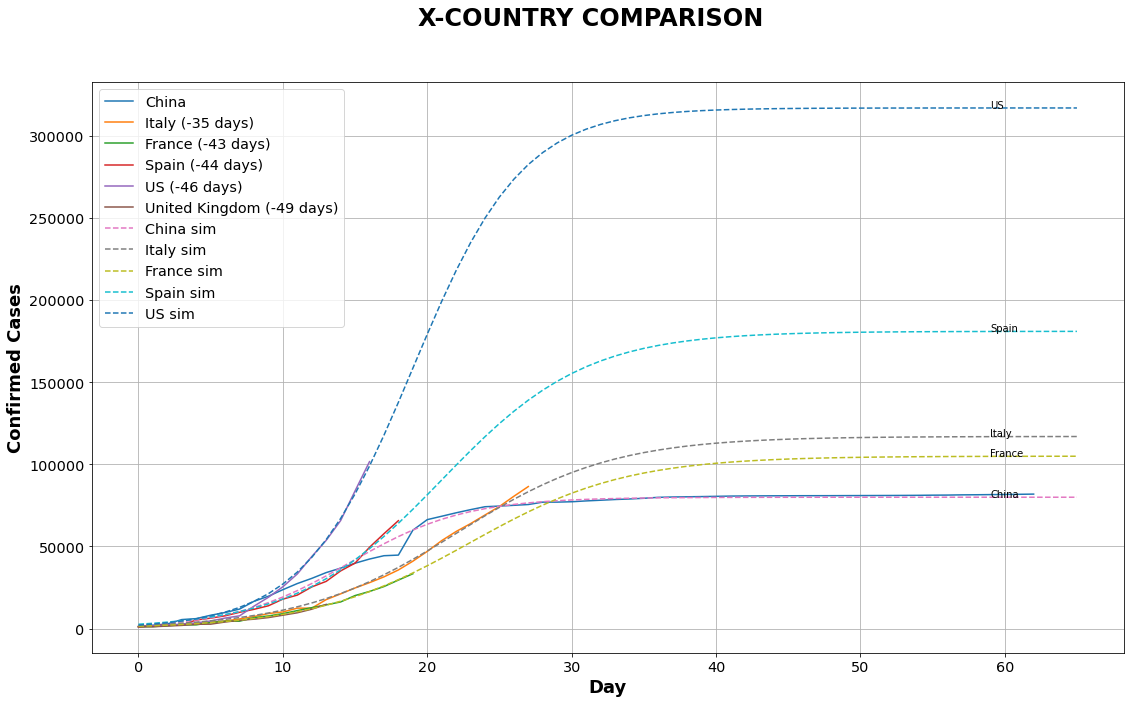

In [83]:
df_sim = pd.DataFrame()

A = {'Italy': 120000.0, 'China': 80000.0, 'France': 105000.0, 'Spain': 180000.0, 'US': 330000.0}
D = {'Italy': 22.0, 'China': 14.0, 'France': 23.0, 'Spain': 21.0, 'US': 19.0}
T = {'Italy': 5.4, 'China': 4.0, 'France': 5.4, 'Spain': 5.0, 'US': 3.8}


def iterate_mse(df_plot, countries, country, param_name, A, D, T):
    epsilon_reference = {'A': 1000, 'D': 0.1, 'T': 0.2}
    max_loop = {'A': 100, 'D': 100, 'T': 100}
    epsilon = {'A': 0, 'D': 0, 'T': 0}
    epsilon[param_name] = epsilon_reference[param_name]
    LAST_MOVE = None
    if VERBOSE:
        print("XXXXXXXXX BEGIN OF ITERATION {} XXXXXXXXX".format(param_name))
    for loop in range(0,max_loop[param_name]):
        relevant_length = len(df_plot[country])-countries[country]
        # zero
        # the sim array is calculated with full length len(df_plot[country])
        sim_0 = [A[country] / (1+math.exp((D[country]-x)/T[country])) for x in range(0,len(df_plot[country]))]
        # the mse is calculated only based on the relevant length and normalized
        mse_0 = ((df_plot[country][0:relevant_length]-sim_0[0:relevant_length])**2).sum() / relevant_length
        # D+
        sim_plus = [(A[country] + epsilon['A']) / (1+math.exp((D[country] + epsilon['D'] - x)/(T[country] + epsilon['T']))) for x in range(0,len(df_plot[country]))]
        mse_plus = ((df_plot[country][0:relevant_length]-sim_plus[0:relevant_length])**2).sum() / relevant_length
        # D-
        sim_minus = [(A[country] - epsilon['A']) / (1+math.exp((D[country] - epsilon['D'] - x)/(T[country] - epsilon['T']))) for x in range(0,len(df_plot[country]))]
        mse_minus = ((df_plot[country][0:relevant_length]-sim_minus[0:relevant_length])**2).sum() / relevant_length
        if VERBOSE:
            print("{:3d} {} mse_minus = {:.3e} ; mse_0 = {:.3e} ; mse_plus = {:.3e}".format(loop, country, mse_minus, mse_0, mse_plus))
        if mse_plus < mse_0:
            if LAST_MOVE == "MINUS":
                    epsilon[param_name] /= 2
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f}".format(param_name, epsilon[param_name]))
            A[country] += epsilon["A"]
            D[country] += epsilon["D"]
            T[country] += epsilon["T"]
            if VERBOSE:
                print(" {}  >>>>>>".format(param_name))
            LAST_MOVE = "PLUS"
        elif mse_minus < mse_0:
            if LAST_MOVE == "PLUS":
                    epsilon[param_name] /= 2
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f}".format(param_name, epsilon[param_name]))
            A[country] -= epsilon["A"]
            D[country] -= epsilon["D"]
            T[country] -= epsilon["T"]
            if VERBOSE:
                print(" {}  <<<<<<".format(param_name))
            LAST_MOVE = "MINUS"
        else:
            if VERBOSE:
                print("Local min found --> Breaking after {} loops".format(loop+1))
            break
    if VERBOSE:
        print("{} {} --> mse = {:.1e} - Sim [0] = {:.0f}".format(country, param_name, mse_0, sim[0]))
        print("XXXXXXXXX END OF ITERATION {} XXXXXXXXX".format(param_name))
    return sim_0

    

for country in ['China', 'Italy', 'France', 'Spain', 'US']:
    sim_0 = iterate_mse(df_plot, countries, country, "A", A, D, T)
    if VERBOSE:
        print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
    sim_0 = iterate_mse(df_plot, countries, country, "D", A, D, T)
    if VERBOSE:
        print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
    sim_0 = iterate_mse(df_plot, countries, country, "D", A, D, T)
    if VERBOSE:
        print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[country], D[country], T[country]))
        print("{} --> mse = {:.1e} - Sim [0] = {:.0f}".format(country, mse, sim[0]))
    df_sim[country] = sim_0



fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('X-COUNTRY COMPARISON', fontsize=24, fontweight='bold')
ax.set_xlabel('Day', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Confirmed Cases', fontsize=18, fontweight='bold')

for country in countries:
    if countries[country] == min_offset:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{}".format(country))
    else:
        ax.plot(df_plot[country][0:len(df_plot[country])-countries[country]], label="{} (-{} days)".format(country, countries[country] - min_offset))

for country in ['China', 'Italy', 'France', 'Spain', 'US']:
    ax.plot(df_sim[country], label = "{} sim".format(country), linestyle='dashed')
    text_x_pos = int(.9 * len(df_sim[country]))
    text_y_pos = int(df_sim[country][text_x_pos])
    plt.text(text_x_pos, text_y_pos, country)

    peak_datetime = origin_datetime + datetime.timedelta(days=countries[country] + D['Italy'])
    print("{} --> peak: {} ; final total cases = {} ; time constant = {:.1f} days".format(country, peak_datetime.strftime("%b %d"), A[country], T[country]))
ax.grid()
ax.legend()

plt.show()






In [232]:
#np.unique(df['Country'])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burma', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'H